## Method #1 VOD Logit Benchmark

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from time import time

In [2]:
cd

/Users/karatechop


In [3]:
cd /Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022\ \(CSV\)

/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022 (CSV)


In [4]:
df = pd.read_csv('working_main_expanded.csv')
print(df.columns,'\n',df.shape)

Index(['date', 'day_in_year', 'time', 'sunsettime', 'dusktime', 'sex', 'race',
       'type', 'duration', 'agency', 'location', 'city', 'lat', 'lon', 'wave',
       'mins_stop_time', 'mins_dawn', 'mins_sunrise', 'mins_sunset',
       'mins_dusk', 'mins_after_dawn', 'mins_before_dusk', 'dark'],
      dtype='object') 
 (2408246, 23)


Let's find the earliest and latest dark periods for dawn and dusk to filter for our ITP

In [10]:
itp_dawn = df[(df['type']!='Non-Moving') &
             ((df['mins_stop_time']>=df.mins_dawn.min()) & (df['mins_stop_time']<=df.mins_dawn.max())) & #filtering for ITP (4:30-8:30)
             ((df['mins_after_dawn']>=30) | (df['mins_after_dawn']<=0))][['date', #removing sunset->dusk period
                                                                          'time',
                                                                          'race',
                                                                          'location',
                                                                          'city',
                                                                          'wave',
                                                                          'mins_after_dawn',
                                                                          'mins_stop_time',
                                                                          'mins_dawn',
                                                                          'dark']]

itp_dawn['period'] = 'dawn'
itp_dawn.shape
itp_dawn.to_csv('itp_dawn.csv',index=False)

In [11]:
itp_dusk = df[(df['type']!='Non-Moving') &
             ((df['mins_stop_time']>=df.mins_dusk.min()) & (df['mins_stop_time']<=df.mins_dusk.max())) & #filtering for ITP (4:30-8:30)
             ((df['mins_before_dusk']>=30) | (df['mins_before_dusk']<=0))][['date', #removing sunset->dusk period
                                                                            'time',
                                                                            'race',
                                                                            'location',
                                                                            'city',
                                                                            'wave',
                                                                            'mins_before_dusk',
                                                                            'mins_stop_time',
                                                                            'mins_dusk',
                                                                            'dark']]
itp_dusk['period'] = 'dusk'
itp_dusk.shape
itp_dusk.to_csv('itp_dusk.csv',index=False)

In [12]:
itp_dusk.shape

(337580, 11)

In [13]:
itp_full = pd.concat([itp_dawn,itp_dusk]).drop(columns=['mins_after_dawn','mins_before_dusk','mins_dawn','mins_dusk'])
itp_full.to_csv('itp_full.csv',index=False)
itp_full.isna().sum()

date              0
time              0
race              0
location          0
city              0
wave              0
mins_stop_time    0
dark              0
period            0
dtype: int64

In [15]:
itp_full.shape

(419353, 9)

## VOD 

In [61]:
import scipy
import statsmodels.formula.api as smf
import statistics as st 

### Statewide VOD Model

In [203]:
#https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/
vod_ca_dusk = pd.get_dummies(itp_dusk, columns = ['race'], drop_first=True, prefix='')\
                       [['date',
                         'location',
                         'city',
                         'wave',
                         'dark',
                         'mins_stop_time',
                         '_hispanic/latino(a)',
                         '_black/african american']].rename(columns={'_black/african american':'black',
                                                                     '_hispanic/latino(a)':'hispanic'})\
                                                 .reset_index(drop=True)
vod_ca_dusk.head(2)
# vod_ca_full.shape

,date,location,city,wave,dark,mins_stop_time,hispanic,black
0,2021-03-12 00:00:00,1100 block of william ct - San Jose,San Jose,2,0,1054.000,1,0
1,2021-01-21 00:00:00,1500 block of moorpark - San Jose,San Jose,2,1,1215.000,0,0


In [220]:
formula = f"black ~ C(dark, Treatment(reference=0)) + mins_stop_time"
log_reg = smf.logit(formula, data = vod_ca_dusk).fit()
results = log_reg.summary()
OR = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    },
)
OR = np.exp(OR)

print(f'{OR}\n\n\n{results}\n\n\n\n\n\n\n\n\n')

Optimization terminated successfully.
         Current function value: 0.576423
         Iterations 5
                                        OR  Lower CI  Upper CI
Intercept                            0.039     0.034     0.046
C(dark, Treatment(reference=0))[T.1] 0.965     0.945     0.985
mins_stop_time                       1.002     1.002     1.002


                           Logit Regression Results                           
Dep. Variable:                  black   No. Observations:               337580
Model:                          Logit   Df Residuals:                   337577
Method:                           MLE   Df Model:                            2
Date:                Sun, 13 Nov 2022   Pseudo R-squ.:                0.002841
Time:                        17:13:30   Log-Likelihood:            -1.9459e+05
converged:                       True   LL-Null:                   -1.9514e+05
Covariance Type:            nonrobust   LLR p-value:                1.641e-241
            

In [ ]:
#PSUEDO
# C(location_POP, Treatment(reference=0) low/medium/high population area, 3 levels
# C(location_FREQ, Treatment(reference=0) low/medium/high stop frequency area, 3 levels
# TABLE GOING INTO PSEUDO SHOULD HAVE 8 COLS (DEP, DARK (1), LOC(3), POP(3))

psuedo_formula = f"black ~ dark + C(location_FREQ, Treatment(reference=0)) + C(location_POP, Treatment(reference=0))"


### By City

In [341]:
la = vod[vod['city'] == 'Los Angeles'].reset_index(drop=True)
la.head(2)
la['location'] = [i.lower().lstrip('').rstrip('') for i in la['location']]
locations_la = la['location'].unique()
len(locations_la)

57260

In [356]:
# la['location'].replace('saint','street',inplace=True)

la['location'] = [i.replace('s ','') for i in la['location'] if len(i.split()[0]) == 1]
la['location'] = [i.replace('e ','') for i in la['location'] if len(i.split()[0]) == 1]
la['location'] = [i.replace('n ','') for i in la['location'] if len(i.split()[0]) == 1]
la['location'] = [i.replace('w ','') for i in la['location'] if len(i.split()[0]) == 1]

la['location'] = la['location'].str.replace(' s ','')
la['location'] = la['location'].str.replace(' n ','')
la['location'] = la['location'].str.replace(' e ','')
la['location'] = la['location'].str.replace(' w ','')
# la['location'] = la['location'].str.replace('san ','')

# expand_start = time()
# la['expanded_location'] = [expand_address(i)[0] for i in la['location']]

# la['location'] = la['location'].str.replace('saint','')
# la['location'] = la['location'].str.replace(' st ','')
# la['location'] = la['location'].str.replace('san ','')
la['location'] = la['location'].str.replace('south ','')
la['location'] = la['location'].str.replace('north ','')
la['location'] = la['location'].str.replace('east ','')
la['location'] = la['location'].str.replace('west ','')




# print(f'debug,expand worked and took {round((time()-expand_start)/60,2)} minutes')

addresses = [i.split('&')[0].rstrip('').lstrip('') + ', los angeles' for i in la['location']]
# addresses = [i.split('&')[0].replace(' - los angeles','').rstrip('').lstrip('') for i in la['location']]

len(pd.unique(addresses))

SyntaxError: invalid syntax (3033127843.py, line 3)

In [349]:
's vermont ave , los angeles'.split()[0]

's'

In [343]:
addresses

['600alvarado st - los angeles, los angeles',
 'vine st , los angeles',
 '56th st , los angeles',
 'abbot kinney , los angeles',
 'palms , los angeles',
 'pacific ave , los angeles',
 'kewen , los angeles',
 'wilcox ave , los angeles',
 'sunset , los angeles',
 'calvert st , los angeles',
 'van nuys blvd , los angeles',
 'washington blvd , los angeles',
 'washington blvd , los angeles',
 'washington blvd , los angeles',
 'washington blvd , los angeles',
 'n sepulveda blvd , los angeles',
 'florence , los angeles',
 'mlk blvd , los angeles',
 'brooks ave , los angeles',
 'lincoln blvd , los angeles',
 's budlong ave , los angeles',
 '7000 bevis ave - los angeles, los angeles',
 '7000 bevis ave - los angeles, los angeles',
 '4000 nicolet ave - los angeles, los angeles',
 '59th pl , los angeles',
 '59th pl , los angeles',
 '59th pl , los angeles',
 '59th pl , los angeles',
 '59th pl , los angeles',
 '59th pl , los angeles',
 'pacific ave , los angeles',
 '4800 slauson ave - los angeles, l

In [378]:
from geopy import Point
from geopy import Nominatim
from postal.parser import parse_address
from postal.expand import expand_address
import googlemaps
from key import key #this is a file ignored in the REPO to privately host my google maps API key

key = key.replace('†','')
gmaps = googlemaps.Client(key=key)
# https://console.cloud.google.com/apis/credentials?project=la-api-key


 API queries_quota: 60 



In [397]:
str(gmaps.geocode('88th place',bounds=la_bounds)[0]['geometry']['location']['lat']) + ' , ' +\
str(gmaps.geocode('88th place',bounds=la_bounds)[0]['geometry']['location']['lng'])

'33.9565039 , -118.2625641'

In [331]:
# addresses = np.array([i.split('&')[0] for i in la['expanded_location']])
# addresses = np.array([i.split('&')[0] for i in la['expanded_location'].str.replace(' los angeles','')])

In [359]:
gmaps.geocode?

In [360]:
la_viewbox = ( (33.525861509262725,-117.32095033303995), (34.26915279876192,-118.52290082214722) )   
la_bounds = gmaps.geocode('los angeles')[0]['geometry']['bounds']

def find_lat_lon(address):
    street = address.split('&')[0]
    
    try:
        geolocator = Nominatim(user_agent="kcharris@berkeley.edu")
        location = geolocator.geocode(street,viewbox=la_viewbox,bounded=True)
    
        location_info = location.raw
        coords = location_info['display_name'].split()[-3].replace(',','')
    
    except:
        
        try:
#             coords = int(gmaps.geocode(street,bounds=la_bounds)[0]['address_components'][-1]['long_name'])
            coords = str(gmaps.geocode('88th place',bounds=la_bounds)[0]['geometry']['location']['lat']) + ' , ' +\
                     str(gmaps.geocode('88th place',bounds=la_bounds)[0]['geometry']['location']['lng'])
        
        except:
            print(f'google maps failed for {street}')
            pass
    
    return coords

ApiError: REQUEST_DENIED (The provided API key is invalid. )

In [198]:
# int(gmaps.geocode('mindanao avenue',bounds=la_bounds)[0]['address_components'][-1]['long_name'])
# # int(geocode_result2[0]['address_components'][-1]['long_name'])

## Method #2 Proportions Before/After Sunset

In [66]:
cd

/Users/karatechop


In [67]:
cd /Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022\ \(CSV\)

/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022 (CSV)


In [68]:
# itp_dawn
# itp_dusk
# itp_full

In [80]:
print(itp_dusk.columns)
itp_dusk.head(2)

Index(['date', 'race', 'location', 'city', 'mins_before_dusk',
       'mins_stop_time', 'mins_dusk', 'dark'],
      dtype='object')


,date,race,location,city,mins_before_dusk,mins_stop_time,mins_dusk,dark
27,2021-03-12 00:00:00,hispanic/latino(a),1100 block of william ct - San Jose,San Jose,65.000,1054.000,1119.000,0
79,2021-01-30 00:00:00,hispanic/latino(a),1300 block of sthal street - San Jose,San Jose,28.000,1050.000,1078.000,0


## CA

In [174]:
df1_bw.race.unique()

array(['hispanic/latino(a)', 'black/african american', 'white', 'asian',
       'group 4'], dtype=object)

In [195]:
df1_bw = itp_dusk[(itp_dusk['mins_before_dusk'] <= 95) &\
                  (itp_dusk['mins_before_dusk'] >= -95)] #&\
#                   (itp_dusk['city']=='Los Angeles')]
#         (df['type']=='Moving')][['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset']]

df1_bw['before_dusk_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_before_dusk']]
prop_table = df1_bw.groupby('before_dusk_category',as_index=False).agg('count')[['before_dusk_category','race']]


#############################################
prop_table['black_aa_stops'] = df1_bw[df1_bw['race']=='black/african american'].groupby('before_dusk_category',as_index=False)\
                                                                   .agg('count')[['before_dusk_category','race']]\
                                                                   .rename(columns={'race':'black_aa'})['black_aa']
prop_table['prop_black_aa'] = round(prop_table['black_aa_stops']/prop_table['race'],4)




prop_table['white_stops'] = df1_bw[df1_bw['race']=='white'].groupby('before_dusk_category',as_index=False)\
                                                                   .agg('count')[['before_dusk_category','race']]\
                                                                   .rename(columns={'race':'white'})['white']
prop_table['prop_white'] = round(prop_table['white_stops']/prop_table['race'],4)




prop_table['hispanic_stops'] = df1_bw[df1_bw['race']=='hispanic/latino(a)'].groupby('before_dusk_category',as_index=False)\
                                                                   .agg('count')[['before_dusk_category','race']]\
                                                                   .rename(columns={'race':'hispanic'})['hispanic']
prop_table['prop_hispanic'] = round(prop_table['hispanic_stops']/prop_table['race'],4)

#############################################


prop_table = prop_table.sort_values(by='before_dusk_category',ascending=False)\
                       .reset_index(drop=True)\
                       .rename(columns={'race':'total_stops'})[['before_dusk_category', 'total_stops', 
                                                                'white_stops','black_aa_stops', 'hispanic_stops',
                                                                'prop_white','prop_black_aa','prop_hispanic']]

prop_table_pre = prop_table[(prop_table['before_dusk_category']>=30)]
prop_table_dusk = prop_table[(prop_table['before_dusk_category']<= 0)]
prop_table

/var/folders/td/yc8lq2qx2ks3ck292tbf6wtm0000gn/T/ipykernel_6220/2521869304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_bw['before_dusk_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_before_dusk']]


,before_dusk_category,total_stops,white_stops,black_aa_stops,hispanic_stops,prop_white,prop_black_aa,prop_hispanic
0,90,9962,1805,2482,4697,0.181,0.249,0.471
1,80,10550,1811,2639,5109,0.172,0.250,0.484
2,70,10645,1875,2678,5084,0.176,0.252,0.478
3,60,11242,1824,2919,5512,0.162,0.260,0.490
4,50,11793,1905,3033,5704,0.162,0.257,0.484
5,40,12348,1946,3247,6035,0.158,0.263,0.489
6,30,7517,1164,2025,3645,0.155,0.269,0.485
7,0,7519,1286,2014,3529,0.171,0.268,0.469
8,-10,15012,2449,4197,6991,0.163,0.280,0.466
9,-20,14985,2449,4185,7067,0.163,0.279,0.472


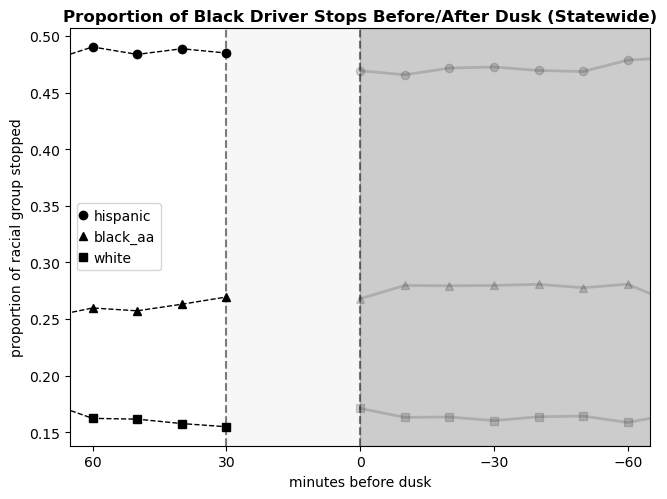

In [222]:
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
fig,ax=plt.subplots()


ax.plot(prop_table_pre['before_dusk_category'],prop_table_pre['prop_hispanic'],linewidth=1,c='black',label='hispanic',marker="o",linestyle='--')
ax.plot(prop_table_pre['before_dusk_category'],prop_table_pre['prop_black_aa'],linewidth=1,c='black',label='black_aa',marker="^",linestyle='--')
ax.plot(prop_table_pre['before_dusk_category'],prop_table_pre['prop_white'],linewidth=1,c='black',label='white',marker="s",linestyle='--')



# ax.scatter(prop_table_sunset['before_dusk_category'],prop_table_sunset['prop'],linewidth=2,c='black',label='reported stops',marker="o")
ax.plot(prop_table_dusk['before_dusk_category'],prop_table_dusk['prop_hispanic'],linewidth=2,c='black',alpha=.15,marker="o")
ax.plot(prop_table_dusk['before_dusk_category'],prop_table_dusk['prop_black_aa'],linewidth=2,c='black',alpha=.15,marker="^")
ax.plot(prop_table_dusk['before_dusk_category'],prop_table_dusk['prop_white'],linewidth=2,c='black',alpha=.15,marker="s")


ax.set_ylabel("proportion of racial group stopped")
ax.set_xlabel('minutes before dusk')


plt.xticks(np.arange(90,-91,-30))
ax.invert_xaxis()

plt.xlim(65,-65)
plt.axvline(x = 30,c='black',alpha=.5,linestyle='dashed')
plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
plt.axvspan(30, 0, color='black', alpha=0.03)
plt.axvspan(0, -95, color='black', alpha=0.2)


plt.title('Proportion of Black Driver Stops Before/After Dusk (Statewide)',weight='semibold',pad=5)
plt.legend()
plt.tight_layout(pad=0, w_pad=2, h_pad=2)

plt.show()

# save the plot as a file
# fig.savefig('/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Notebooks/Exports/Total Stops vs Proportion Black Civil Twilight (CA).jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [197]:
df1_bw = df1_bw.reset_index(drop=True)

light = df1_bw[(df1_bw['dark']==0)&\
              ((df1_bw['mins_before_dusk'] >-15) | (df1_bw['mins_before_dusk'] < 15))]
prop_light = (light[light['race'] == 'black/african american']).shape[0]/light.shape[0]

dark = df1_bw[(df1_bw['dark']==1)&\
              ((df1_bw['mins_before_dusk'] >-15) | (df1_bw['mins_before_dusk'] < 15))]
prop_dark = (dark[dark['race'] == 'black/african american']).shape[0]/dark.shape[0]

print(f'light:{prop_light}\n dark:{prop_dark}')

light:0.2568697084678018
 dark:0.2756760495193305


In [132]:
# grouped_hours = hour_test[(hour_test['mins_stop_time']>=(60*15))&(hour_test['mins_stop_time']<=(60*22))]
# plt.xticks(np.arange(0,(60*24.5),60),rotation=60)

# for i in hour_test.race.unique():
#     grouped_hours = hour_test[hour_test['race']==i].groupby('mins_stop_time',as_index=False).agg('count')[['mins_stop_time','race']]
#     plt.plot(grouped_hours.mins_stop_time,grouped_hours.race,label=f'{i}')

# # plt.axvline(x = 1020,c='black',alpha=.8,linestyle='dashed')
# # plt.axvline(x = 1200,c='black',alpha=.8,linestyle='dashed')
# # plt.axvspan(0, 1020, color='black', alpha=0.2)
# # plt.axvspan(1200, 1440, color='black', alpha=0.2)
# plt.axvline(x = 1020,c='black',alpha=.8,linestyle='dashed')
# plt.axvspan(1020, 1440, color='black', alpha=0.2)

# plt.axvline(x = 1200,c='black',alpha=.4,linestyle='dashed')
# plt.axvspan(1200, 1440, color='black', alpha=0.35)

# plt.xlim(360,1440)
# plt.ylim(0,2000)

# plt.legend(fontsize=6,borderpad=1,loc='upper left')